In [1]:
# Run this line in Colab to install the package if it is
# not already installed.
!pip install git+https://github.com/openai/glide-text2im

  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-oskeejp5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/glide-text2im /tmp/pip-req-build-oskeejp5
  Resolved https://github.com/openai/glide-text2im to commit 69b530740eb6cef69442d6180579ef5ba9ef063e
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
  Created wheel for glide-text2im: filename=glide_text2im-0.0.0-py3-none-any.whl size=1953624 sha256=92ec5a1cdcab32621d04e896ea29e5b8c298cb81dc7eed6864cdc56b87b24cd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-wmzwnkej/wheels/88/21/5e/57cab1c1078317022fe11d86e1596fdaa12260531220ac0c99
Successfully built glide-text2im


In [2]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [3]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [66]:
# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

/usr/local/lib/python3.10/dist-packages/glide_text2im/download.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return th.load(path, map_location=device)


total base parameters 385030726


In [5]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398361286


In [64]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [65]:
# Sampling parameters
prompt = "a dog kicking to ball"
batch_size = 1
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

In [63]:
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    )
)

# Create a classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)

AttributeError: 'CLIP' object has no attribute 'tokenizer'

  0%|          | 0/27 [00:00<?, ?it/s]

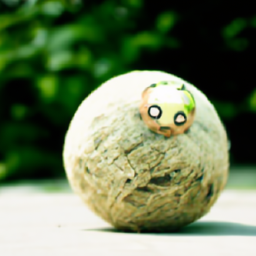

In [32]:
##############################
# Upsample the 64x64 samples #
##############################

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

# Show the output
show_images(up_samples)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 10.6 MB/s eta 0:00:00


In [33]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip train2017.zip
!unzip annotations_trainval2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: train2017/000000563584.jpg  
 extracting: train2017/000000276069.jpg  
 extracting: train2017/000000401194.jpg  
 extracting: train2017/000000502089.jpg  
 extracting: train2017/000000192183.jpg  
 extracting: train2017/000000425127.jpg  
 extracting: train2017/000000126766.jpg  
 extracting: train2017/000000324161.jpg  
 extracting: train2017/000000452746.jpg  
 extracting: train2017/000000423782.jpg  
 extracting: train2017/000000546343.jpg  
 extracting: train2017/000000249290.jpg  
 extracting: train2017/000000025529.jpg  
 extracting: train2017/000000316928.jpg  
 extracting: train2017/000000337866.jpg  
 extracting: train2017/000000547768.jpg  
 extracting: train2017/000000423162.jpg  
 extracting: train2017/000000224149.jpg  
 extracting: train2017/000000117841.jpg  
 extracting: train2017/000000251660.jpg  
 extracting: train2017/000000110997.jpg  
 extracting: train2017/000000424728.jpg  
 extracting: train2017/00

Seperate the COCO Dataset

In [148]:
import os
import json
import shutil
import random
from tqdm import tqdm

# --- Paths ---
coco_images_path = '/content/train2017'  # Path to COCO images
coco_annotations_path = '/content/annotations/captions_train2017.json'  # Captions annotation file

output_dir = '/content/output/'  # Directory where train/val/test folders will be saved
os.makedirs(output_dir, exist_ok=True)

# Paths for train, validation, and test splits
train_images_path = os.path.join(output_dir, 'train2017')
val_images_path = os.path.join(output_dir, 'val2017')
test_images_path = os.path.join(output_dir, 'test2017')

# Create directories for image splits
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(val_images_path, exist_ok=True)
os.makedirs(test_images_path, exist_ok=True)

# --- Load COCO Captions JSON ---
with open(coco_annotations_path, 'r') as f:
    coco_data = json.load(f)

images = coco_data['images']  # List of all images
annotations = coco_data['annotations']  # List of all annotations

# --- Shuffle and Split Data ---
random.seed(42)  # For reproducibility
random.shuffle(images)

num_images = len(images)
train_split = int(0.8 * num_images)
val_split = int(0.9 * num_images)

train_images = images[:train_split]
val_images = images[train_split:val_split]
test_images = images[val_split:]

print(f"Total images: {num_images}, Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")

# --- Split Captions ---
def get_annotations_for_images(images_subset, annotations):
    image_ids = {img['id'] for img in images_subset}
    return [ann for ann in annotations if ann['image_id'] in image_ids]

train_annotations = get_annotations_for_images(train_images, annotations)
val_annotations = get_annotations_for_images(val_images, annotations)
test_annotations = get_annotations_for_images(test_images, annotations)

# --- Organize Captions into JSON-Friendly Format ---
def format_data(images_subset, annotations_subset):
    formatted_data = {
        "images": images_subset,
        "annotations": []
    }
    for ann in annotations_subset:
        formatted_data["annotations"].append({
            "image_id": ann['image_id'],
            "caption": ann['caption'],
            "id": ann['id']  # Ensure we retain the annotation ID for traceability
        })
    return formatted_data

# --- Save JSON Files ---
def save_json(data, path):
    with open(path, 'w') as f:
        json.dump(data, f, indent=4)

train_data = format_data(train_images, train_annotations)
val_data = format_data(val_images, val_annotations)
test_data = format_data(test_images, test_annotations)

save_json(train_data, os.path.join(output_dir, 'captions_train2017.json'))
save_json(val_data, os.path.join(output_dir, 'captions_val2017.json'))
save_json(test_data, os.path.join(output_dir, 'captions_test2017.json'))

# --- Copy Images to Corresponding Directories ---
def copy_images(images_subset, src_folder, dest_folder):
    for img_info in tqdm(images_subset, desc=f"Copying to {dest_folder}"):
        img_filename = img_info['file_name']
        src_path = os.path.join(src_folder, img_filename)
        dest_path = os.path.join(dest_folder, img_filename)
        shutil.copy(src_path, dest_path)

copy_images(train_images, coco_images_path, train_images_path)
copy_images(val_images, coco_images_path, val_images_path)
copy_images(test_images, coco_images_path, test_images_path)

print("Data split and files copied successfully!")

Total images: 118287, Train: 94629, Val: 11829, Test: 11829


Copying to /content/output/test2017: 100%|██████████| 11829/11829 [00:08<00:00, 1362.17it/s]

Data split and files copied successfully!


In [161]:
# --- Paths ---
coco_annotations_path = '/content/output/captions_test2017.json'  # Captions annotation file
coco_images_path = '/content/output/test2017'  # Path to COCO images
output_dir = '/content/output/'  # Directory where output will be saved
os.makedirs(output_dir, exist_ok=True)

# --- Load COCO Captions JSON ---
with open(coco_annotations_path, 'r') as f:
    coco_data = json.load(f)

images = coco_data['images']  # List of all images
annotations = coco_data['annotations']  # List of all annotations

# --- Shuffle and Split Data ---
random.seed(42)  # For reproducibility
random.shuffle(images)

num_images = len(images)
train_split = int(0.8 * num_images)
val_split = int(0.9 * num_images)

train_images = images[:train_split]

def get_annotations_for_images(images_subset, annotations):
    image_ids = {img['id'] for img in images_subset}
    return [ann for ann in annotations if ann['image_id'] in image_ids]

train_annotations = get_annotations_for_images(train_images, annotations)
train_captions_list = [ann['caption'] for ann in train_annotations]

# --- Save Train Captions to a File ---
captions_file_path = os.path.join(output_dir, 'train_captions_list.txt')
with open(captions_file_path, 'w') as f:
    for caption in train_captions_list:
        f.write(caption + '\n')

print(f"Total train captions: {len(train_captions_list)}")
print(f"First 5 train captions: {train_captions_list[:5]}")

# --- Save 5 Images to Files ---
images_save_dir = os.path.join(output_dir, 'sample_images')
os.makedirs(images_save_dir, exist_ok=True)
captions_text = []
counter = 0
for img_info in train_images[:5]:  # First 5 images
    counter += 1
    image_path = os.path.join(coco_images_path, img_info['file_name'])  # Get image path from JSON
    image_name = f"train_image_{counter}.png"  # Save image as "train_image_1.png", etc.
    image_save_path = os.path.join(images_save_dir, image_name)
    try:
        # Open image and save
        image = Image.open(image_path)
        image.save(image_save_path)
        print(f"Saved {image_save_path}")

        # Print corresponding caption
        related_captions = [ann['caption'] for ann in train_annotations if ann['image_id'] == img_info['id']]
        print(f"Captions for {image_name}: {related_captions}")
        captions_text.append(related_captions[0])

    except Exception as e:
        print(f"Error loading image {image_path}: {e}")

Total train captions: 47339
First 5 train captions: ['A bicycle replica with a clock as the front wheel.', 'The bike has a clock as a tire.', 'A black metal bicycle with a clock inside the front wheel.', 'The back door with a window in the kitchen.', 'A tiny bathroom with only a toilet and a shelf.']
Saved /content/output/sample_images/train_image_1.png
Captions for train_image_1.png: ["Several bundles of green and yellow banana's hanging around a table.", 'A large number of bananas hanging outside a building.', 'Bunches of banana are hanging from the roof in a shop.', 'Bunches of plantains and bananas on display at open air market.', 'Banana bunches hanging at an open air market.']
Saved /content/output/sample_images/train_image_2.png
Captions for train_image_2.png: ['Several large kites are soaring through the air.', 'A picture of a lot of kites in the air.', 'Kites are being flown in the sky, near a tree.', 'several kites flying high in the sky on a clear day', 'many kites flying in

In [157]:
captions_text

["Several bundles of green and yellow banana's hanging around a table.",
 'Several large kites are soaring through the air.',
 'A cow is grazing in the grass near tall reeds. ',
 'The traffic and people on a commercial street corner at night',
 'a street sign on a narrow city street and a building with grafiti']

In [160]:
from PIL import Image
# --- Copy and Resize Images ---
def copy_and_resize_images(images_subset, src_folder, dest_folder):
    for img_info in tqdm(images_subset, desc=f"Resizing and copying to {dest_folder}"):
        img_filename = img_info['file_name']
        src_path = os.path.join(src_folder, img_filename)
        dest_path = os.path.join(dest_folder, img_filename)

        # Open and resize image
        with Image.open(src_path) as img:
            img_resized = img.resize((64, 64))  # Resize to 64x64
            img_resized.save(dest_path)

copy_and_resize_images(test_images, coco_images_path, test_images_path)

print("Data split, resized images, and files saved successfully!")

Resizing and copying to /content/output/test2017: 100%|██████████| 11829/11829 [01:12<00:00, 163.71it/s]

Data split, resized images, and files saved successfully!


In [126]:
import matplotlib.pyplot as plt

def show_first_n_images_inline(image_folder, n=10):
    """Display the first `n` images from a folder inline using matplotlib."""
    image_files = os.listdir(image_folder)[:n]  # Get first `n` image filenames
    plt.figure(figsize=(15, 5))

    for i, img_filename in enumerate(image_files):
        img_path = os.path.join(image_folder, img_filename)
        with Image.open(img_path) as img:
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Image {i + 1}")

    plt.show()
train_images[1]


{'license': 1,
 'file_name': '000000338948.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000338948.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-17 03:48:38',
 'flickr_url': 'http://farm9.staticflickr.com/8423/7867726662_7b75467722_z.jpg',
 'id': 338948}

Generate Images Using Glide Model

In [61]:
# Store the values in seperate file

from PIL import Image
import os

# Function to save and show the image
def save_and_show_images(up_samples, prompt, output_dir="generated_images"):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Iterate through samples and save them
    for idx, sample in enumerate(up_samples):
        # Convert tensor to numpy and format it as an image
        image_array = ((sample.permute(1, 2, 0).cpu().numpy() + 1) * 127.5).astype('uint8')
        img = Image.fromarray(image_array)

        # Save the image using the prompt name or a unique identifier
        image_filename = f"{prompt.replace(' ', '_')}_{idx}.png"
        image_path = os.path.join(output_dir, image_filename)
        img.save(image_path)
        print(f"Image saved at {image_path}")

        # Optionally display the image
        img.show()
    return  image_path

# Directory to save images (change the path as desired)
output_directory = "custom_directory_for_images2"

CLIP Score

In [52]:
!pip install torch torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-84eu7adz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-84eu7adz
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=6cf998813ed5e946dd425b2584b70f520331c7c0f358346ce77eecd6e13ddc6f
  Stored in directory: /tmp/pip-ephem-wheel-cache-b0p0rzss/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [67]:
import torch
import clip
from PIL import Image

# Function to compute CLIP score
def compute_clip_score(image_path, text_prompt):
    # Load and preprocess the image
    # Load the CLIP model and preprocess function
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_clip, preprocess = clip.load("ViT-B/32", device=device)
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    # Encode the image and text
    text = clip.tokenize([text_prompt]).to(device)
    with torch.no_grad():
        image_features = model_clip.encode_image(image)
        text_features = model_clip.encode_text(text)

    # Normalize features to unit vectors
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Compute cosine similarity (CLIP score)
    similarity = (image_features @ text_features.T).item()

    return similarity


FID

In [54]:
!pip install torch torchvision scipy numpy pillow tqdm
!pip install git+https://github.com/mseitzer/pytorch-fid.git

  Cloning https://github.com/mseitzer/pytorch-fid.git to /tmp/pip-req-build-r85h8ou7
  Running command git clone --filter=blob:none --quiet https://github.com/mseitzer/pytorch-fid.git /tmp/pip-req-build-r85h8ou7
  Resolved https://github.com/mseitzer/pytorch-fid.git to commit b9c18118d082cbd263c1b8963fc4221dc1cbb659
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pytorch-fid: filename=pytorch_fid-0.3.0-py3-none-any.whl size=15523 sha256=de122f960f71cf914c18f38596aa4690e7d5b9d054fe60eedb859ed930ee9711
  Stored in directory: /tmp/pip-ephem-wheel-cache-dhchn8vr/wheels/46/5a/da/7becec0590adb9cd8d43d11ad63328ad9cfdf224852823ee33
Successfully built pytorch-fid


In [56]:
import torch
from pytorch_fid import fid_score

# Function to compute FID for text-to-image generation
def compute_text_to_image_fid(real_images_dir, generated_images_dir, batch_size=16):
    """
    real_images_dir: Path to directory containing real images corresponding to text prompts.
    generated_images_dir: Path to directory containing images generated from text prompts.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Compute FID between real and generated image sets
    fid_value = fid_score.calculate_fid_given_paths([real_images_dir, generated_images_dir],
    batch_size=batch_size,
    device=device,
    dims=2048)
    print(f"FID Score (Text-to-Image): {fid_value:.4f}")
    return fid_value

# Example Usage
real_images_path = "/content/output/test2017"  # Real images (e.g., from MS COCO)
generated_images_path = "/content/custom_directory_for_images"  # Model-generated images
fid_score_value = compute_text_to_image_fid(real_images_path, generated_images_path,32)

100%|██████████| 370/370 [00:17<00:00, 20.80it/s]


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


FID Score (Text-to-Image): 457.2374


Diveristy Score

In [75]:
import torch
import clip
from PIL import Image
import numpy as np
from itertools import combinations



# Function to compute Diversity Score
def compute_diversity_score(image_paths):
    """
    Compute diversity score (DS) for a set of generated images.

    Args:
    - image_paths: List of paths to generated images.

    Returns:
    - diversity_score: The average pairwise cosine distance between image embeddings.
    """
    image_embeddings = []
    # Load CLIP model and preprocessing
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    # Extract embeddings for each image
    for img_path in image_paths:
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_embedding = model.encode_image(image)
            image_embedding /= image_embedding.norm(dim=-1, keepdim=True)  # Normalize embeddings
            image_embeddings.append(image_embedding.cpu().numpy().squeeze())

    # Convert list to numpy array
    image_embeddings = np.array(image_embeddings)

    # Compute pairwise cosine distances
    pairwise_distances = []
    for (img1, img2) in combinations(image_embeddings, 2):
        cosine_similarity = np.dot(img1, img2) / (np.linalg.norm(img1) * np.linalg.norm(img2))
        distance = 1 - cosine_similarity  # Cosine distance
        pairwise_distances.append(distance)

    # Average pairwise distance as diversity score
    diversity_score_mean = np.mean(pairwise_distances)
    diveristy_score_std = np.std(pairwise_distances)
    print(f"Diversity Score (DS): {diversity_score_mean:.4f} +/- {diveristy_score_std:.4f}")
    return diversity_score_mean, diveristy_score_std



Insecption Score (IS)

Testing

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Several bundles of green and yellow banana's hanging around a table.


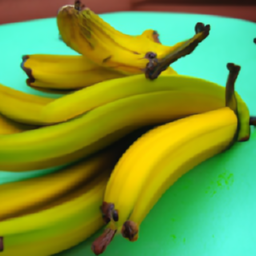

Image saved at custom_directory_for_images2/Several_bundles_of_green_and_yellow_banana's_hanging_around_a_table._0.png
CLIP Score: 0.2952


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Several large kites are soaring through the air.


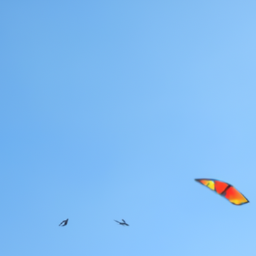

Image saved at custom_directory_for_images2/Several_large_kites_are_soaring_through_the_air._0.png
CLIP Score: 0.3193


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

A cow is grazing in the grass near tall reeds. 


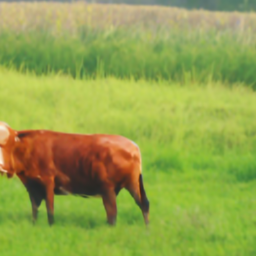

Image saved at custom_directory_for_images2/A_cow_is_grazing_in_the_grass_near_tall_reeds.__0.png
CLIP Score: 0.3125


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

The traffic and people on a commercial street corner at night


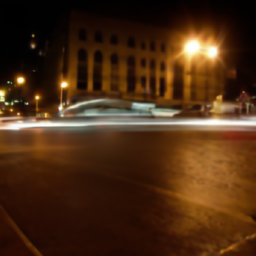

Image saved at custom_directory_for_images2/The_traffic_and_people_on_a_commercial_street_corner_at_night_0.png
CLIP Score: 0.2847


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

a street sign on a narrow city street and a building with grafiti


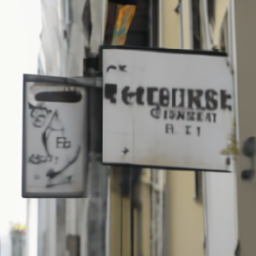

Image saved at custom_directory_for_images2/a_street_sign_on_a_narrow_city_street_and_a_building_with_grafiti_0.png
CLIP Score: 0.2900
Average CLIP Score: 0.3003
Diversity Score (DS): 0.3636 +/- 0.0668


(0.363623046875, 0.06678682664392195)

In [163]:
import torch
import clip
from PIL import Image

generated_paths = []
average_total_clip = 0

for i in captions_text:
    # Sampling parameters
    prompt = i
    batch_size = 1
    guidance_scale = 3.0
    # Directory to save images (change the path as desired)
    output_directory = "custom_directory_for_images2"

    # Tune this parameter to control the sharpness of 256x256 images.
    # A value of 1.0 is sharper, but sometimes results in grainy artifacts.
    upsample_temp = 0.997
    ##############################
    # Sample from the base model #
    ##############################

    # Create the text tokens to feed to the model.
    tokens = model.tokenizer.encode(prompt)
    tokens, mask = model.tokenizer.padded_tokens_and_mask(
        tokens, options['text_ctx']
    )

    # Create the classifier-free guidance tokens (empty)
    full_batch_size = batch_size * 2
    uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
        [], options['text_ctx']
    )

    # Pack the tokens together into model kwargs.
    model_kwargs = dict(
        tokens=th.tensor(
            [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
        ),
        mask=th.tensor(
            [mask] * batch_size + [uncond_mask] * batch_size,
            dtype=th.bool,
            device=device,
        ),
    )

    # Create a classifier-free guidance sampling function
    def model_fn(x_t, ts, **kwargs):
        half = x_t[: len(x_t) // 2]
        combined = th.cat([half, half], dim=0)
        model_out = model(combined, ts, **kwargs)
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
        eps = th.cat([half_eps, half_eps], dim=0)
        return th.cat([eps, rest], dim=1)

    # Sample from the base model.
    model.del_cache()
    samples = diffusion.p_sample_loop(
        model_fn,
        (full_batch_size, 3, options["image_size"], options["image_size"]),
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
    model.del_cache()

    ##############################
    # Upsample the 64x64 samples #
    ##############################

    tokens = model_up.tokenizer.encode(prompt)
    tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
        tokens, options_up['text_ctx']
    )

    # Create the model conditioning dict.
    model_kwargs = dict(
        # Low-res image to upsample.
        low_res=((samples+1)*127.5).round()/127.5 - 1,

        # Text tokens
        tokens=th.tensor(
            [tokens] * batch_size, device=device
        ),
        mask=th.tensor(
            [mask] * batch_size,
            dtype=th.bool,
            device=device,
        ),
    )

    # Sample from the base model.
    model_up.del_cache()
    up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
    up_samples = diffusion_up.ddim_sample_loop(
        model_up,
        up_shape,
        noise=th.randn(up_shape, device=device) * upsample_temp,
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
    model_up.del_cache()
    print(i)

    # Show the output
    show_images(up_samples)
    image_path = save_and_show_images(up_samples, i, output_dir=output_directory)
    # Example Usage

    # Generating CLIP Score
    clip_score = compute_clip_score(image_path, prompt)

    generated_paths.append(image_path)
    # Checking for Intensity socre
    average_total_clip += clip_score
    print(f"CLIP Score: {clip_score:.4f}")


# Average CLIP Score
average_total_clip /= 5
print(f"Average CLIP Score: {average_total_clip:.4f}")

# Generating Diveristy Score
compute_diversity_score(generated_paths)



In [165]:
# Checking for FID Score
real_images_path = "/content/output/sample_images"  # Real images (e.g., from MS COCO)
generated_images_path = "/content/custom_directory_for_images2"  # Model-generated images
fid_score_value = compute_text_to_image_fid(real_images_path, generated_images_path,1)
print(f"FID Score: {fid_score_value:.4f}")

100%|██████████| 5/5 [00:00<00:00, 18.06it/s]


FID Score (Text-to-Image): 472.3358
FID Score: 472.3358


In [106]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
from scipy.stats import entropy
import numpy as np

# Function to compute the Inception Score
def compute_inception_score(images, splits=2):
    """
    Compute the Inception Score for a batch of generated images.
    Arguments:
        images: A list of PIL images or torch tensors.
        splits: Number of splits for computing IS.
    Returns:
        mean IS and standard deviation.
    """
    preds = []

    # Load pretrained InceptionV3 model for feature extraction
    device = "cuda" if torch.cuda.is_available() else "cpu"
    inception_model = models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()  # Set to evaluation mode

    # Image preprocessing for InceptionV3
    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),  # InceptionV3 expects 299x299 images
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize based on ImageNet stats
    ])

    with torch.no_grad():
        for img in images:
            if isinstance(img, Image.Image):
                img = preprocess(img).unsqueeze(0).to(device)
                if img.shape[1:] != (3, 299, 299):
                    print(f"Warning: Image shape is {img.shape}. Skipping invalid input.")
                    continue

                logits = inception_model(img)
                probabilities = F.softmax(logits, dim=1).cpu().numpy()  # Get probability distribution
                preds.append(probabilities)

    # Check if preds is empty
    if len(preds) == 0:
        print("Error: No valid predictions. Check image inputs.")
        return np.nan, np.nan

    preds = np.concatenate(preds, axis=0)  # Shape: (num_images, 1000 classes)
    scores = []

    for i in range(splits):
        part = preds[i * (len(preds) // splits):(i + 1) * (len(preds) // splits)]
        py = np.mean(part, axis=0)  # Marginal distribution p(y)
        kl_scores = [entropy(pyx, py) for pyx in part]
        if np.isnan(kl_scores).any():
            print("Warning: NaN detected in KL divergence. Skipping this split.")
            continue
        scores.append(np.exp(np.mean(kl_scores)))  # KL divergence + exponentiation

    if len(scores) == 0:
        print("Error: No valid splits. Returning NaN.")
        return np.nan, np.nan

    mean_score = np.mean(scores)
    std_score = np.std(scores)

    return mean_score, std_score

# Example usage
# List of generated image paths
images = [Image.open(img_path).convert("RGB") for img_path in generated_paths]  # Convert to RGB to avoid shape issues

mean_is, std_is = compute_inception_score(images)
print(f"Inception Score: Mean = {mean_is:.2f}, Std = {std_is:.2f}")

Error: No valid predictions. Check image inputs.
Inception Score: Mean = nan, Std = nan


In [116]:
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from PIL import Image
import numpy as np
import os
import torch.nn.functional as F

# Function to load and preprocess images
def load_images_from_folder(folder_path):
    images = []
    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # Inception v3 input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".png"):
            image_path = os.path.join(folder_path, file_name)
            image = Image.open(image_path).convert('RGB')
            image = transform(image)
            images.append(image)
    if len(images) == 0:
        raise ValueError("No PNG images found in the folder.")
    return torch.stack(images)

# Calculate KL Divergence and Inception Score
def calculate_inception_score(images, batch_size=1, splits=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load pretrained Inception V3 model with correct weights
    weights = Inception_V3_Weights.DEFAULT
    inception_model = inception_v3(weights=weights).to(device)
    inception_model.eval()

    n_images = images.shape[0]
    if n_images < batch_size:
        batch_size = n_images  # Set batch size to number of images to avoid issues

    preds = []

    with torch.no_grad():
        for i in range(0, n_images, batch_size):
            batch = images[i:i + batch_size].to(device)
            output = inception_model(batch)
            preds.append(F.softmax(output, dim=1).cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    # Calculate inception score
    split_scores = []
    for k in range(splits):
        start = k * (n_images // splits)
        end = (k + 1) * (n_images // splits)
        part = preds[start:end, :]

        if len(part) == 0:
            continue  # Skip if empty

        p_y = np.mean(part, axis=0)  # Marginal distribution
        scores = []
        for i in range(part.shape[0]):
            p_y_given_x = part[i]  # Conditional distribution
            kl_div = p_y_given_x * (np.log(p_y_given_x + 1e-10) - np.log(p_y + 1e-10))
            scores.append(np.sum(kl_div))
        split_scores.append(np.exp(np.mean(scores)))

    print(split_scores)



    inception_score = np.mean(split_scores)
    std_dev = np.std(split_scores)
    return inception_score, std_dev

# Main function to compute IS score
def compute_inception_score(folder_path):
    images = load_images_from_folder(folder_path)
    inception_score, std_dev = calculate_inception_score(images)
    print(f"Inception Score: {inception_score:.2f} ± {std_dev:.2f}")
    return inception_score

# Specify the folder where PNG files are stored
folder_path = "/content/custom_directory_for_images"
compute_inception_score(folder_path)

[1.9890467, 1.8274987]
Inception Score: 1.91 ± 0.08


1.9082727

ValueError: could not convert string to float: 'This is a blue and white bathroom with a wall sink and a lifesaver on the wall.'